# Data Analysis

This notebook is used to generate the figures in Rüdisser et al. 2025.

### Importing packages

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from tqdm import tqdm

from loguru import logger

# hide all logs except for errors
logger.remove()
logger.add(sys.stderr, level="ERROR")

from scripts.data.visualise.insitu_geosphere import prop

geo_cornflowerblue = "dodgerblue"
geo_green2 = "dodgerblue"
geo_lime = "gold"
geo_magenta = "firebrick"

from src.arcane2.data.realtime.realtime_insitu_dataset import RealtimeInsituDataset
from src.arcane2.data.catalogs.icmecat_dataset import ICMECAT_Dataset
from src.arcane2.data.abstract.multi_signal_dataset import MultiSignalDataset
from src.arcane2.data.abstract.sequential_dataset import SequentialDataset

### Create rtsw data

In [3]:
folder_path_rtsw = project_root / "data/noaa_archive_gsm.p"

components = ["bx", "by", "bz", "bt", "vt", "np", "tp", "beta"]
padding = "drop"

full_dataset_rtsw = RealtimeInsituDataset(
    folder_path=folder_path_rtsw,
    components=components,
    resample=False,
    padding=padding,
    scaling="None",
)

### Plot rtsw data

In [4]:
df = full_dataset_rtsw.data
df.index = pd.to_datetime(df["timestamp"], unit="s")
subdf = df.loc["2023-11-01":"2023-11-15"]

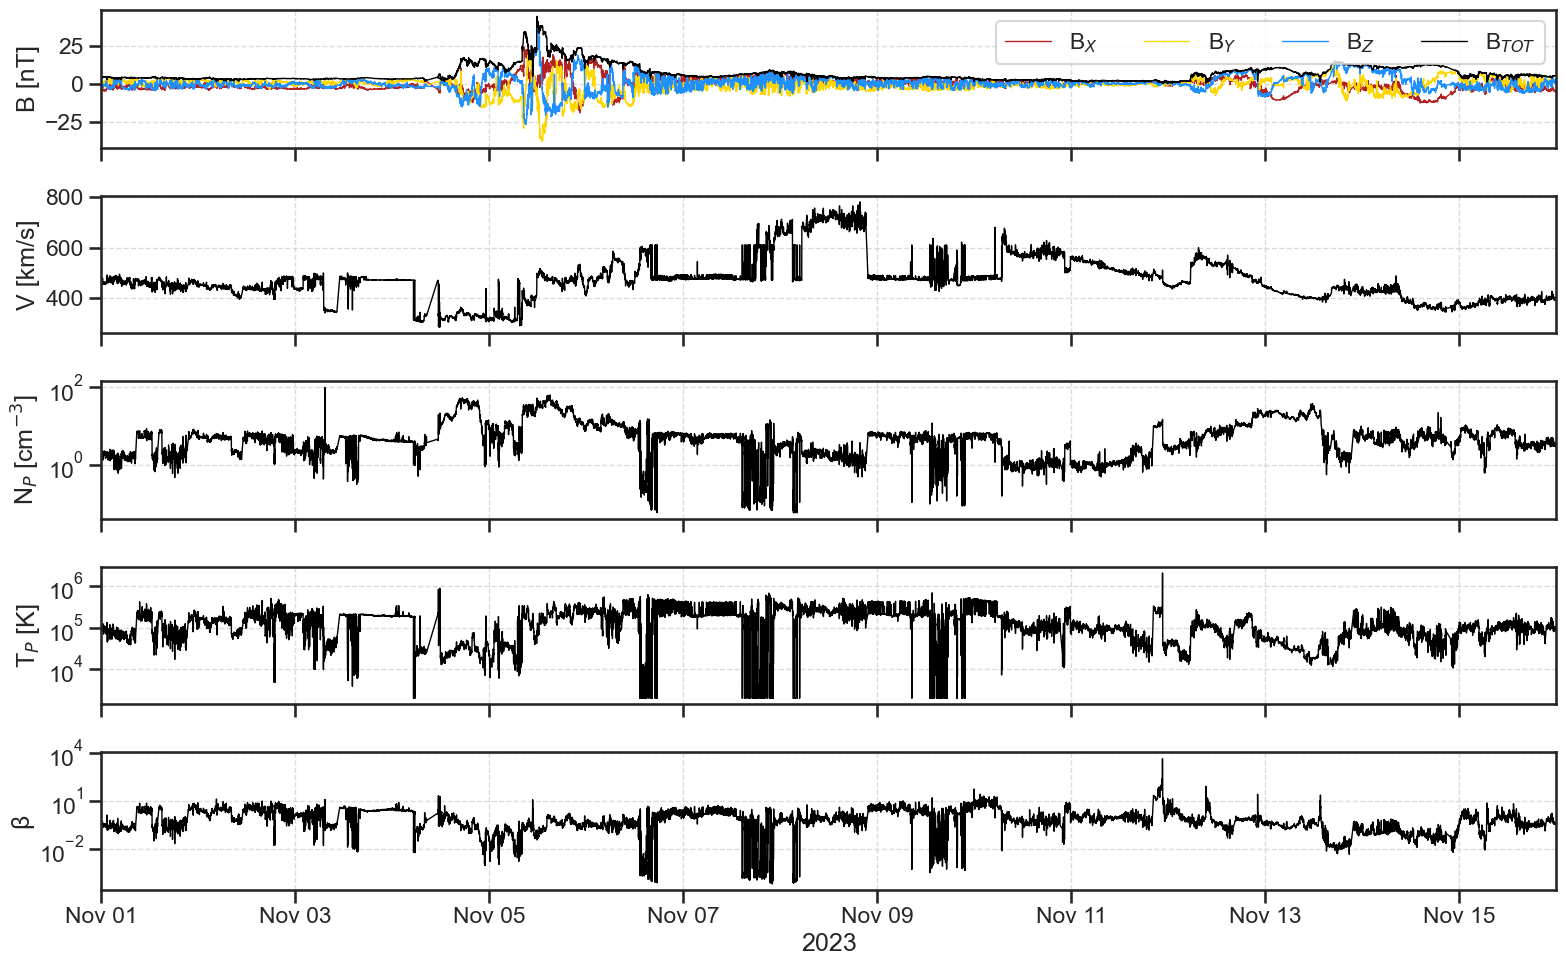

In [5]:
import matplotlib.dates as mdates
import matplotlib.ticker as mticker



fig, axes = plt.subplots(5, 1, figsize=(16, 10))

axes[0].plot(subdf.index, subdf["bx"], label="B$_{X}$", color=geo_magenta, linewidth=1)
axes[0].plot(subdf.index, subdf["by"], label="B$_{Y}$", color=geo_lime, linewidth=1)
axes[0].plot(subdf.index, subdf["bz"], label="B$_{Z}$", color=geo_green2, linewidth=1)
axes[0].plot(subdf.index, subdf["bt"], label="B$_{TOT}$", color="black", linewidth=1)

axes[0].legend(loc="upper right", ncol=4)
axes[0].set_ylabel("B [nT]")

axes[1].plot(subdf.index, subdf["vt"], color="black", linewidth=1)
axes[1].set_ylabel("V [km/s]")

axes[2].plot(subdf.index, subdf["np"], color="black", linewidth=1)
axes[2].set_yscale("log")
axes[2].set_ylabel("N$_P$ [cm$^{-3}$]")

axes[3].plot(subdf.index, subdf["tp"], color="black", linewidth=1)
axes[3].set_yscale("log")
axes[3].set_ylabel("T$_P$ [K]")
axes[3].yaxis.set_minor_locator(mticker.NullLocator())

axes[4].plot(subdf.index, subdf["beta"], color="black", linewidth=1)
axes[4].set_yscale("log")
axes[4].set_ylabel("\u03B2")
axes[4].set_xlabel(str(subdf.index.min().year))
axes[4].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))

for ax in axes:
    ax.set_xlim(subdf.index.min(), subdf.index.max())
    ax.grid(True, which="both", linestyle="--", linewidth=1, alpha=0.7)
    ax.label_outer()  # Hides x tick labels for all but the bottom subplot

plt.tight_layout()
plt.savefig("../../plots/rtsw_data.pdf")

### Create catalog data

In [6]:
catalog_paths = [
    "https://helioforecast.space/static/sync/icmecat/HELIO4CAST_ICMECAT_v23.csv"
]
event_types = "ICME"
startname = "icme_start_time"
endname = "mo_end_time"

catalog_dataset = ICMECAT_Dataset(
    folder_paths=catalog_paths,
    event_types=event_types,
    startname=startname,
    endname=endname,
)

100%|██████████| 533/533 [00:02<00:00, 195.38it/s]


### Determine the time range of the datasets

In [7]:
catalog_timestamps = pd.to_datetime(catalog_dataset.data['timestamp'], unit='s')
catalog_begin = catalog_timestamps.iloc[0]
catalog_end = catalog_timestamps.iloc[-1]

print(f"The catalog spans from {catalog_begin} to {catalog_end}")

The catalog spans from 1995-02-07 19:10:00 to 2024-12-17 14:20:00


In [8]:
full_dataset_rtsw_timestamps = pd.to_datetime(full_dataset_rtsw.data["timestamp"], unit="s")

print(f"The RTSW dataset spans from {full_dataset_rtsw_timestamps.iloc[0]} to {full_dataset_rtsw_timestamps.iloc[-1]}")

full_dataset_rtsw_with_catalog = full_dataset_rtsw.data[full_dataset_rtsw.data["timestamp"].between(catalog_begin.timestamp(), catalog_end.timestamp())]
full_dataset_rtsw_with_catalog.index = pd.to_datetime(full_dataset_rtsw_with_catalog["timestamp"], unit="s")

print(f"The RTSW dataset with catalog spans from {pd.to_datetime(full_dataset_rtsw_with_catalog['timestamp'], unit='s').iloc[0]} to {pd.to_datetime(full_dataset_rtsw_with_catalog['timestamp'], unit='s').iloc[-1]} and has {full_dataset_rtsw_with_catalog.shape[0]} rows with a mean sampling rate of {full_dataset_rtsw_with_catalog['timestamp'].diff().mean()} seconds")

The RTSW dataset spans from 1998-02-16 00:00:00 to 2025-06-26 13:37:00
The RTSW dataset with catalog spans from 1998-02-16 00:00:00 to 2024-12-17 14:20:00 and has 12774444 rows with a mean sampling rate of 66.29314483613885 seconds


### Determine missing data percentage

In [9]:
# Define function to calculate missing data percentage
def calculate_missing_percentage(dataframe):
    """
    This function calculates the missing data percentage of a given dataframe.
    """

    dataframe = dataframe.copy().dropna()

    # get minimum and maximum timestamps
    min_timestamp = dataframe.index.min()
    max_timestamp = dataframe.index.max()

    # calculate minimal frequency
    min_freq = dataframe.index.diff().min()

    # calculate expected number of rows
    expected_rows = (max_timestamp - min_timestamp) / min_freq

    # calculate missing rows
    missing_rows = expected_rows - dataframe.shape[0]

    # calculate missing percentage
    missing_percentage = missing_rows / expected_rows * 100

    print(f"Missing percentage: {missing_percentage} %")
    print(f"Minimal frequency: {min_freq}")
    
    return missing_percentage, min_freq.total_seconds()/60

def calculate_missing_percentage_event(event, dataframe):
    """
    This function calculates the missing data percentage of a given dataframe for a given event.
    """

    dataframe = dataframe.copy().dropna()

    min_freq = dataframe.index.diff().min()

    # calculate expected number of rows
    expected_rows = (event.end.round(min_freq)-event.begin.round(min_freq)) / min_freq + 2.0

    # calculate missing rows
    missing_rows = expected_rows - dataframe[event.begin.round(min_freq):event.end.round(min_freq)].shape[0]

    # calculate missing percentage
    missing_percentage = missing_rows / expected_rows * 100

    return missing_percentage, min_freq.total_seconds()/60
    

In [10]:
# Calculate missing data percentage
print("RTSW dataset:")
missing_percentage_rtsw, min_freq_rtsw = calculate_missing_percentage(full_dataset_rtsw_with_catalog)

RTSW dataset:
Missing percentage: 9.492897274395471 %
Minimal frequency: 0 days 00:01:00


In [11]:
# Resample the dataset and calculate missing data percentage

resamples = ["1min","10min", "30min", "1h", "3h", "6h", "12h", "1d"]

missing_percentage_rtsw = []

for resample in resamples:
    resampled_rtsw = full_dataset_rtsw_with_catalog.resample(resample).mean()

    resampled_rtsw = resampled_rtsw.dropna()
    
    print(f"Resample: {resample}")

    print("RTSW dataset:")
    missing_percentage_rtsw.append(calculate_missing_percentage(resampled_rtsw))


Resample: 1min
RTSW dataset:
Missing percentage: 9.492897274395471 %
Minimal frequency: 0 days 00:01:00
Resample: 10min
RTSW dataset:
Missing percentage: 3.2840452590635034 %
Minimal frequency: 0 days 00:10:00
Resample: 30min
RTSW dataset:
Missing percentage: 2.397146719492599 %
Minimal frequency: 0 days 00:30:00
Resample: 1h
RTSW dataset:
Missing percentage: 1.8003043725928634 %
Minimal frequency: 0 days 01:00:00
Resample: 3h
RTSW dataset:
Missing percentage: 1.0240779472529715 %
Minimal frequency: 0 days 03:00:00
Resample: 6h
RTSW dataset:
Missing percentage: 0.7473345916441362 %
Minimal frequency: 0 days 06:00:00
Resample: 12h
RTSW dataset:
Missing percentage: 0.5407335611896138 %
Minimal frequency: 0 days 12:00:00
Resample: 1d
RTSW dataset:
Missing percentage: 0.42852770125497397 %
Minimal frequency: 1 days 00:00:00


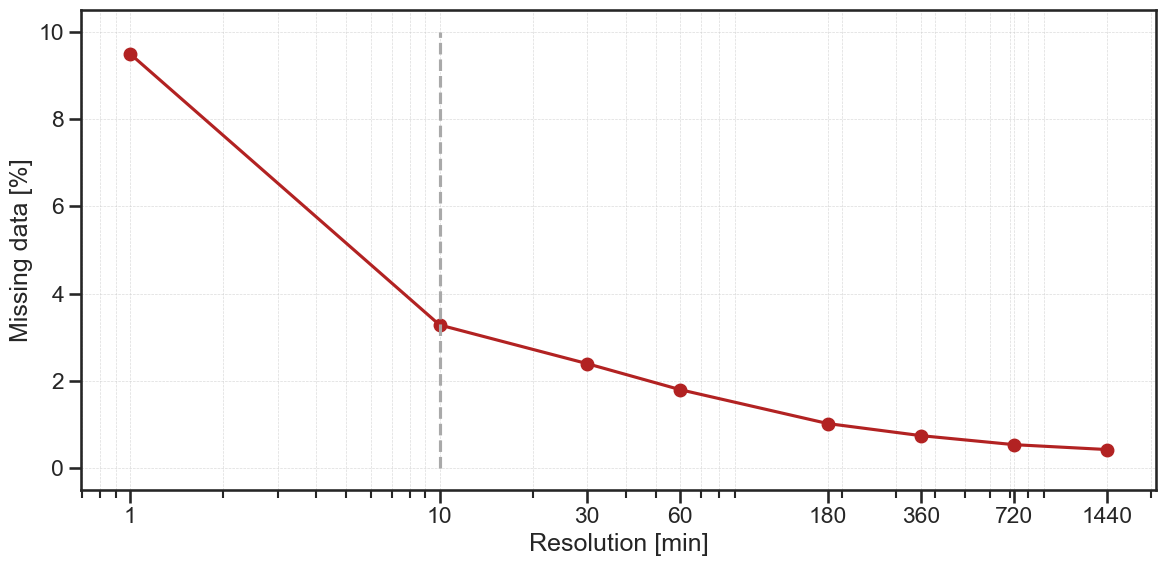

In [12]:
# plot missing data percentage as a function of resample frequency

missing_percentage_rtsw = np.array(missing_percentage_rtsw)

plt.figure(figsize=(12, 6))
plt.plot(
    missing_percentage_rtsw[:,1], 
    missing_percentage_rtsw[:, 0],
    label="RTSW", 
    marker="o",
    color=geo_magenta,
    )

plt.plot(
    [10, 10],
    [0, 10],
    color="darkgrey",
    linestyle="--",
)

# Custom x-ticks
xticks = missing_percentage_rtsw[:, 1]
plt.xscale("log")
plt.xticks(xticks, labels=[str(int(x)) for x in xticks])

plt.xlabel("Resolution [min]")
plt.ylabel("Missing data [%]")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("../../plots/missing_data_percentage.pdf")

In [13]:
# resample the datasets to 30min and generate events

chosen_freq = "10min"

missing_event_data_RTWS = []

resampled_rtsw = full_dataset_rtsw_with_catalog.resample(chosen_freq).mean().dropna()

resampled_events = ICMECAT_Dataset(
    folder_paths=catalog_paths,
    event_types=event_types,
    startname=startname,
    endname=endname
    )

events_rtsw = [event for event in resampled_events.catalog.event_cat if event.begin > resampled_rtsw.index[0] and event.begin < resampled_rtsw.index[-1]]

print(f"Number of events in RTSW dataset: {len(events_rtsw)}")

100%|██████████| 533/533 [00:02<00:00, 189.98it/s]

Number of events in RTSW dataset: 486


In [14]:
# # calculate missing data percentage for each event

for event in tqdm(events_rtsw):
    missing_event_data_RTWS.append(calculate_missing_percentage_event(event, resampled_rtsw))


100%|██████████| 486/486 [00:33<00:00, 14.54it/s]


In [15]:
# determine number of events with missing data higher than a certain threshold

def get_number_of_events_with_missing_higher_than(missing_data, threshold):
    return len([x for x in missing_data if x[0] > threshold])

thresholds = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

rtsw_cum_line = []

for threshold in thresholds:
    print(f"Threshold: {threshold}")
    rtsw_cum_line.append(get_number_of_events_with_missing_higher_than(missing_event_data_RTWS, threshold))
    print(f"Number of events with missing data higher than {threshold}% in RTSW dataset: {get_number_of_events_with_missing_higher_than(missing_event_data_RTWS, threshold)}")

Threshold: 0
Number of events with missing data higher than 0% in RTSW dataset: 486
Threshold: 10
Number of events with missing data higher than 10% in RTSW dataset: 54
Threshold: 20
Number of events with missing data higher than 20% in RTSW dataset: 17
Threshold: 30
Number of events with missing data higher than 30% in RTSW dataset: 9
Threshold: 40
Number of events with missing data higher than 40% in RTSW dataset: 6
Threshold: 50
Number of events with missing data higher than 50% in RTSW dataset: 4
Threshold: 60
Number of events with missing data higher than 60% in RTSW dataset: 3
Threshold: 70
Number of events with missing data higher than 70% in RTSW dataset: 3
Threshold: 80
Number of events with missing data higher than 80% in RTSW dataset: 2
Threshold: 90
Number of events with missing data higher than 90% in RTSW dataset: 1
Threshold: 100
Number of events with missing data higher than 100% in RTSW dataset: 0


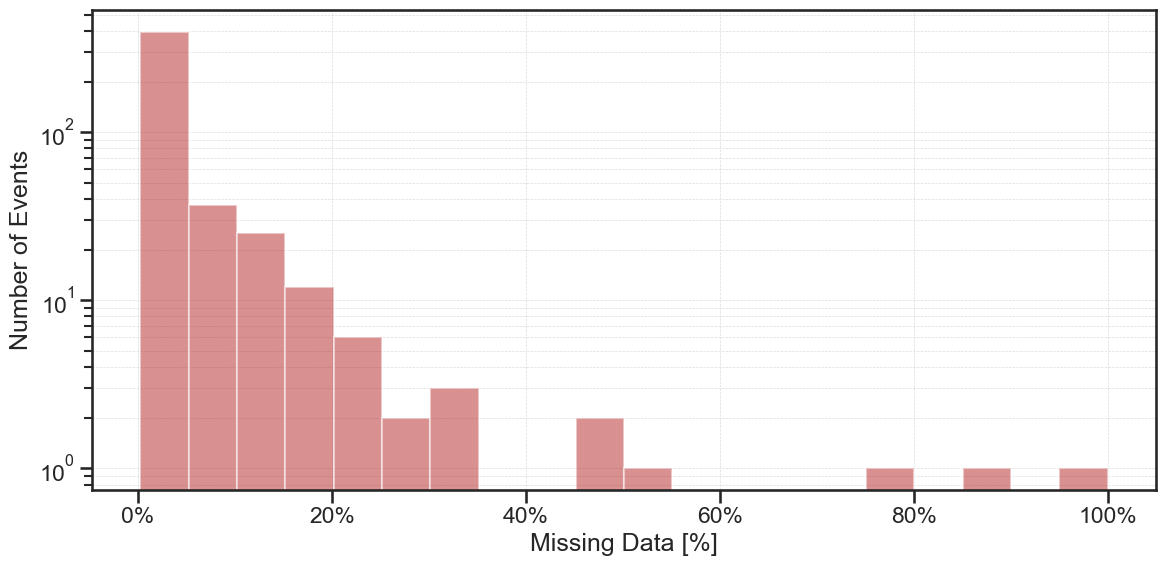

In [16]:
# plot number of events with missing data higher than a certain threshold as histogram

num_bins = 20

common_bins = np.linspace(
    min(np.min(missing_event_data_RTWS), np.min(missing_event_data_RTWS)), 
    max(np.max(missing_event_data_RTWS), np.max(missing_event_data_RTWS)), 
    num_bins + 1
)

plt.figure(figsize=(12, 6))

plt.hist(
    np.array(missing_event_data_RTWS)[:, 0],
    label="RTSW", 
    color=geo_magenta,
    bins=common_bins,
    alpha=0.5,
    )

plt.xlabel("Missing Data [%]")
plt.ylabel("Number of Events")
plt.yscale("log")
plt.gca().xaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, _: f"{x:.0f}%")
    ) 
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.savefig("../../plots/missing_event_percentage.pdf")

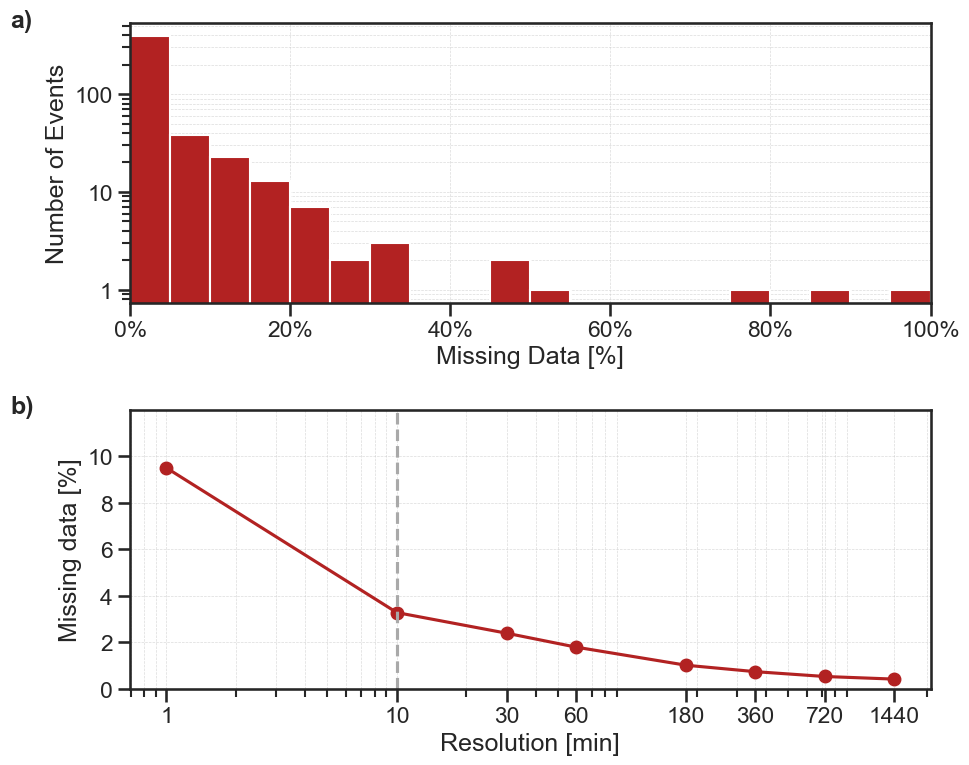

In [17]:
# plot missing data percentage as a function of resample frequency
common_bins = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
# Compute histogram manually
hist_values, bin_edges = np.histogram(np.array(missing_event_data_RTWS)[:, 0], bins=common_bins)

# Shift bar positions to left-aligned bins
bar_positions = bin_edges[:-1]

# Set bar width to match bin width
bar_widths = np.diff(bin_edges)

combined_fig, combined_axs = plt.subplots(2, 1, figsize=(10, 8))

# Compute bin centers (for bar placement and x-ticks)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Plot bars centered on bin centers
combined_axs[0].bar(
    bin_centers,
    hist_values,
    width=5,
    align="center",
    color=geo_magenta,
    label="RTSW",
    log=True,
)

combined_axs[0].set_xlabel("Missing Data [%]")
combined_axs[0].set_ylabel("Number of Events")
combined_axs[0].set_yscale("log")
combined_axs[0].xaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, _: f"{x:.0f}%")
    ) 
combined_axs[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
combined_axs[0].set_yticks([1, 10, 100])
combined_axs[0].set_yticklabels(["1", "10", "100"])
combined_axs[0].set_xlim(0, 100)

combined_axs[1].plot(
    missing_percentage_rtsw[:,1], 
    missing_percentage_rtsw[:, 0],
    label="RTSW", 
    marker="o",
    color=geo_magenta,
    )

combined_axs[1].plot(
    [10, 10],
    [0, 12],
    color="darkgrey",
    linestyle="--",
)

# Custom x-ticks
xticks = missing_percentage_rtsw[:, 1]
combined_axs[1].set_xscale("log")
combined_axs[1].set_xticks(xticks, labels=[str(int(x)) for x in xticks])

# Add subplot labels
combined_axs[0].text(-0.15, 1.05, "a)", transform=combined_axs[0].transAxes,
                     fontweight='bold', va='top', ha='left')

combined_axs[1].text(-0.15, 1.05, "b)", transform=combined_axs[1].transAxes,
                     fontweight='bold', va='top', ha='left')

combined_axs[1].set_xlabel("Resolution [min]")
combined_axs[1].set_ylabel("Missing data [%]")
combined_axs[1].set_ylim(0,12)
combined_axs[1].set_yticks([0, 2, 4, 6, 8, 10])
combined_axs[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
combined_fig.tight_layout()
combined_fig.savefig("../../plots/combined_data.pdf")

In [18]:
# calculate duration of data gaps

data_gap_duration_RTWS = full_dataset_rtsw_with_catalog.index.diff().total_seconds()/60

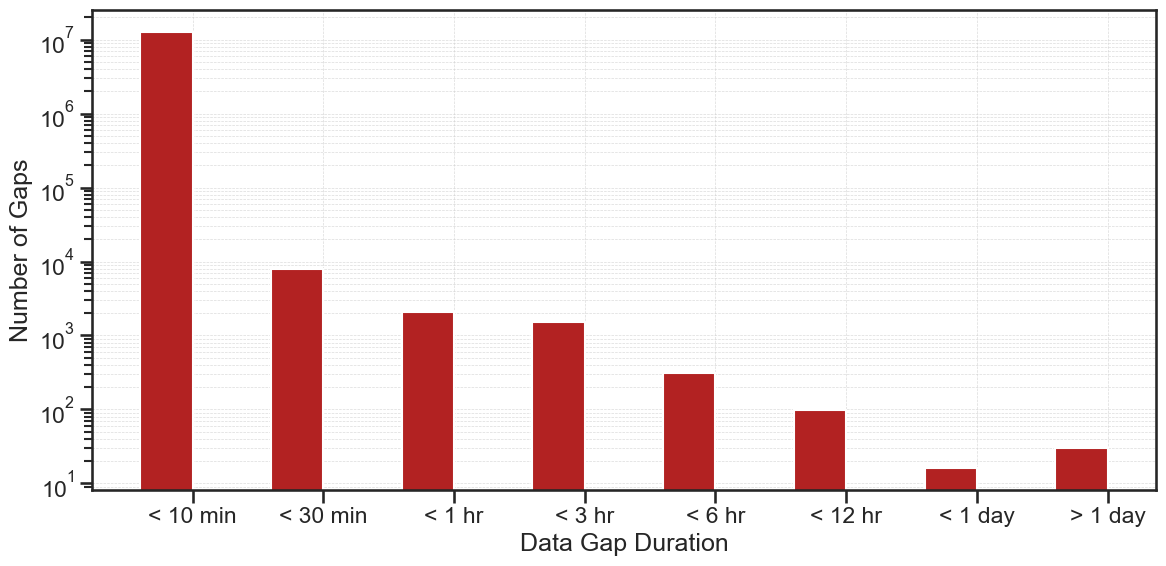

In [19]:
# Plot histogram of data gap durations

# Bin edges and their corresponding labels
bins = [1, 10, 30, 60, 60*3, 60*6, 60*12, 60*24, float("inf")]
bin_labels = [ '< 10 min', '< 30 min', '< 1 hr', '< 3 hr', '< 6 hr', '< 12 hr', '< 1 day', '> 1 day']

# Histogram data for RTSW
RTWS_counts, _ = np.histogram(data_gap_duration_RTWS, bins=bins)

# Plot
plt.figure(figsize=(12, 6))

# Bar positions for evenly spaced labels
x_positions = np.arange(len(bin_labels))

# RTSW histogram bars
plt.bar(
    x_positions - 0.2,  # Offset for the first set of bars
    RTWS_counts,
    width=0.4,
    label="RTSW",
    color=geo_magenta,
)

# Set x-axis with evenly spaced labels
plt.xticks(x_positions, bin_labels)
plt.xlabel("Data Gap Duration")
plt.ylabel("Number of Gaps")
plt.yscale("log")

# Grid and layout
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Save the figure
plt.savefig("../../plots/data_gap_durations.pdf")
plt.show()

In [21]:
# Resample the dataset to 10min

resampled_dataset_rtsw = RealtimeInsituDataset(
    folder_path=folder_path_rtsw,
    components=components,
    resample=True,
    resample_method="mean",
    resample_freq=chosen_freq,
    padding=padding,
    lin_interpol=36,
    
)

In [23]:
# create multi signal datasets and sequential datasets

multi_signal_rtsw_dataset = MultiSignalDataset(
    single_signal_datasets=[catalog_dataset, resampled_dataset_rtsw],
    catalog_idx=0,
)

sequential_rtsw = SequentialDataset(
    dataset=multi_signal_rtsw_dataset,
    n_samples=1024,
    max_time_gap=10.0,
    filters=False,
    filter_key="ICMECAT_catalog-ICME",
    weights=True,
    weight_type="binary",
    weight_factor=10.0,
)

print(sequential_rtsw)

Merging timestamps: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
Dataset: 0: 1570436it [00:00, 2599186.10it/s]
Dataset: 1: 1429765it [00:00, 3737771.30it/s]
Filling:: 2it [00:01,  1.98it/s]
100%|██████████| 141/141 [04:03<00:00,  1.72s/it]

Sequential - 1292261 samples
	MultiSignalDataset - 1402266 samples
	Datasets: 2
	
	0 -------------
		ICMECAT - Wind ICME: 1570436 samples
	1 -------------
		NOAA Realtime Archive - bx by bz bt vt np tp beta: 1429765 samples
	------------------
	


In [24]:
# Calculate missing data percentage

print("RTSW dataset:")
missing_percentage_rtsw_resampled, min_freq_rtsw_resampled = calculate_missing_percentage(multi_signal_rtsw_dataset.df)

RTSW dataset:
Missing percentage: 0.6492705979042531 %
Minimal frequency: 0 days 00:10:00


In [25]:
# extract weights to determine percentage of events vs non events

rtsw_weights = sequential_rtsw.weights

In [26]:
print("RTSW dataset:")
print(f"Number of samples = {len(rtsw_weights)}")
print(f"Number of positive samples = {np.sum((rtsw_weights - 1)/9)}")
print(f"Number of negative samples = {len(rtsw_weights) - np.sum((rtsw_weights - 1)/9)}")
print(f"Percentage of positive samples = {np.sum((rtsw_weights - 1)/9)/len(rtsw_weights)*100}%")


RTSW dataset:
Number of samples = 1292261
Number of positive samples = 76066.0
Number of negative samples = 1216195.0
Percentage of positive samples = 5.886272200430099%


In [58]:
#extract one example from the dataset to check date and time
nr = 1260500

sequential_rtsw.get_data(nr)
pd.to_datetime(sequential_rtsw.get_timestamp(nr), unit="s").to_pydatetime()

datetime.datetime(2024, 5, 3, 15, 0)

In [59]:
def plot_item(index):
    """
    This function plots a single item from the dataset.
    """
    item = sequential_rtsw.get_data(index)

    timestamp = sequential_rtsw.get_timestamp(index)

    print(item.keys())
    print(pd.to_datetime((timestamp), unit="s").to_pydatetime())

    print(item["NOAA Realtime Archive_insitu-bt"].shape)

    time = np.arange(0, item["NOAA Realtime Archive_insitu-bt"].shape[0])

    fig, axes = plt.subplots(5, 1, figsize=(16, 10))

    # Plot the 4 magnetic field components (bx, by, bz, bt) in the first subplot
    axes[0].plot(time, item["NOAA Realtime Archive_insitu-bx"], label="B$_{X}$", color=geo_magenta)
    axes[0].plot(time, item["NOAA Realtime Archive_insitu-by"], label="B$_{Y}$", color=geo_lime)
    axes[0].plot(time, item["NOAA Realtime Archive_insitu-bz"], label="B$_{Z}$", color=geo_green2)
    axes[0].plot(time, item["NOAA Realtime Archive_insitu-bt"], label="B$_{TOT}$", color = "black")
    
    axes[0].set_ylabel("B [nT]")
    axes[0].tick_params(bottom=False, labelbottom=False)

    #axes[0].legend()

    # Plot the remaining components in the other subplots
    axes[1].plot(time, item["NOAA Realtime Archive_insitu-vt"], color = "black")
    axes[1].set_ylabel("V [km/s]")

    axes[2].plot(time, item["NOAA Realtime Archive_insitu-np"], color = "black")
    axes[2].set_ylabel("N$_{P}$ [cm$^{-3}$]")

    axes[3].plot(time, item["NOAA Realtime Archive_insitu-tp"], color = "black")
    axes[3].set_ylabel("T$_{P}$ [K]")

    axes[4].plot(time, item["NOAA Realtime Archive_insitu-beta"], color = "black")
    axes[4].set_ylabel("\u03B2")

    plt.tight_layout()

    plt.savefig("../../plots/plotitem.svg")

dict_keys(['ICMECAT_catalog-ICME', 'ICMECAT_catalog-event_id', 'NOAA Realtime Archive_insitu-bx', 'NOAA Realtime Archive_insitu-by', 'NOAA Realtime Archive_insitu-bz', 'NOAA Realtime Archive_insitu-bt', 'NOAA Realtime Archive_insitu-vt', 'NOAA Realtime Archive_insitu-np', 'NOAA Realtime Archive_insitu-tp', 'NOAA Realtime Archive_insitu-beta'])
2024-05-03 15:00:00
(1024,)


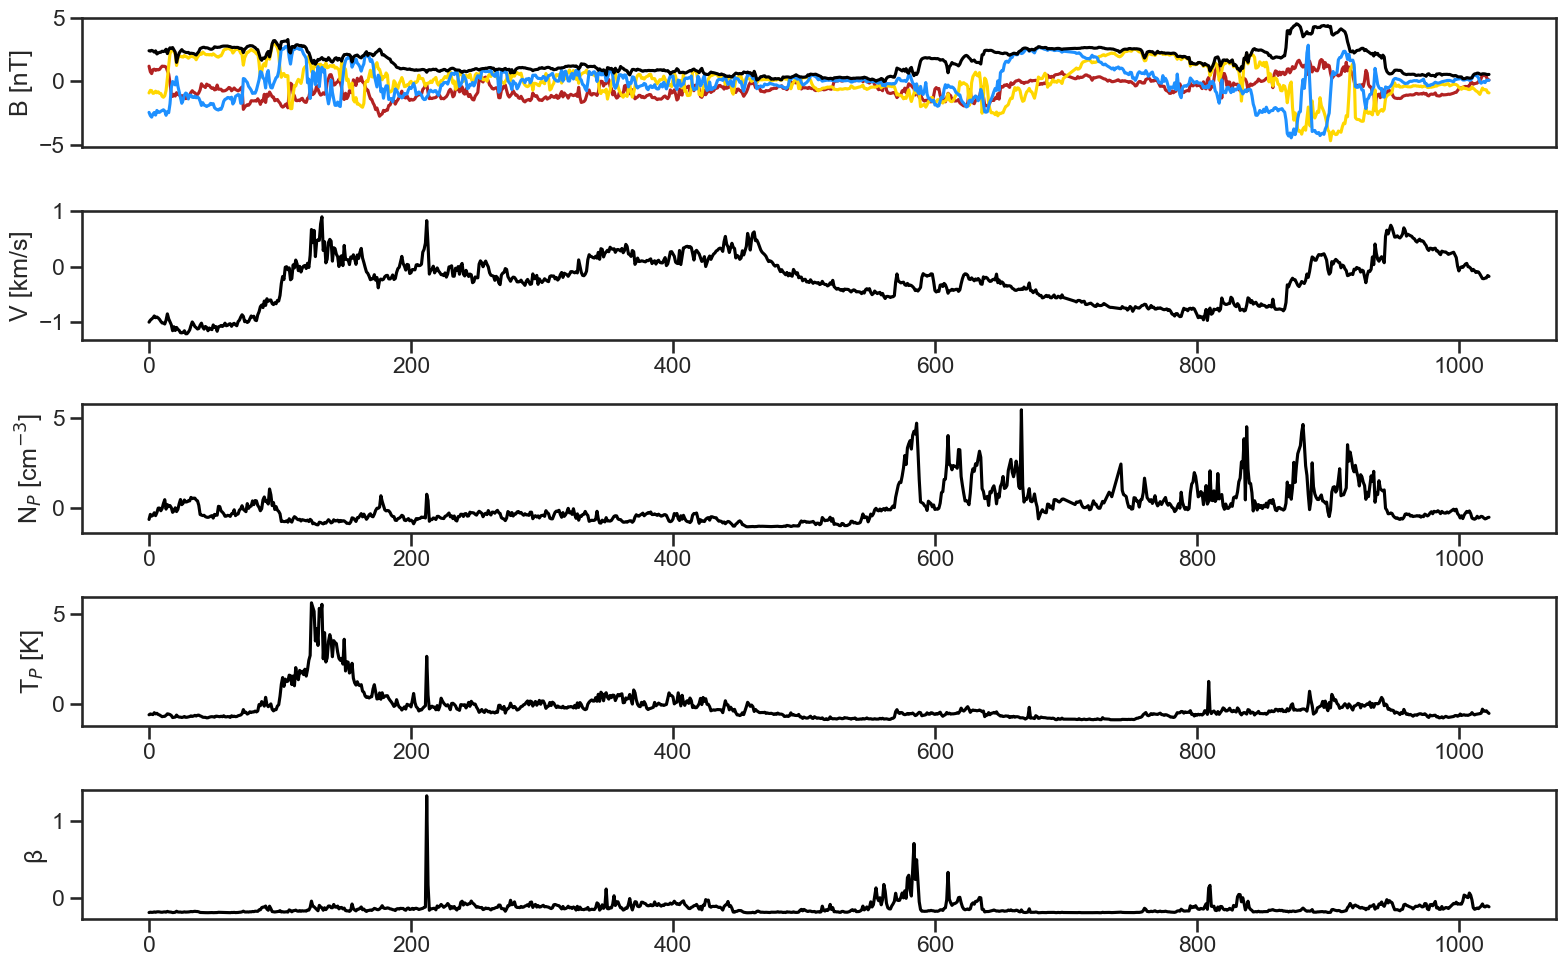

In [60]:
plot_item(nr)

In [69]:
def plot_item_minimal(index):
    """
    This function plots a single item from the dataset in a minimalistic way.
    """

    item = sequential_rtsw.get_data(index)

    timestamp = sequential_rtsw.get_timestamp(index)

    time = np.arange(0, item["NOAA Realtime Archive_insitu-bt"].shape[0])

    fig, ax = plt.subplots(1, 1, figsize=(4, 6),
                           layout='constrained')
    
    line1 = item["NOAA Realtime Archive_insitu-bt"]
    line1a = item["NOAA Realtime Archive_insitu-bx"]
    line1b = item["NOAA Realtime Archive_insitu-by"]
    line1c = item["NOAA Realtime Archive_insitu-bz"]

    line2 = item["NOAA Realtime Archive_insitu-vt"]
    line3 = item["NOAA Realtime Archive_insitu-np"]
    line4 = item["NOAA Realtime Archive_insitu-tp"]
    line5 = item["NOAA Realtime Archive_insitu-beta"]
    
    max1 = np.max([np.max(line1), np.max(line1a), np.max(line1b), np.max(line1c)])
    min1 = np.min([np.min(line1), np.min(line1a), np.min(line1b), np.min(line1c)])

    print(f"Normalizing line 1: {max1} - {min1}")
    # normalize lines between 0 and 1
    line1 = (line1 - min1) / (max1 - min1)
    line1a = (line1a - min1) / (max1 - min1)
    line1b = (line1b - min1) / (max1 - min1)
    line1c = (line1c - min1) / (max1 - min1)

    print(f"Normalizing line 2: {np.max(line2)} - {np.min(line2)}")
    line2 = (line2 - np.min(line2)) / (np.max(line2) - np.min(line2))
    
    print(f"Normalizing line 3: {np.max(line3)} - {np.min(line3)}")
    line3 = (line3 - np.min(line3)) / (np.max(line3) - np.min(line3))

    print(f"Normalizing line 4: {np.max(line4)} - {np.min(line4)}")
    line4 = (line4 - np.min(line4)) / (np.max(line4) - np.min(line4))

    print(f"Normalizing line 5: {np.max(line5)} - {np.min(line5)}")
    line5 = (line5 - np.min(line5)) / (np.max(line5) - np.min(line5))
    
    yticklabels = [
        "\u03B2",
        "T$_{P}$ [K]",
        "N$_{P}$ [cm$^{-3}$]",
        "V [km/s]",
        "B [nT]",
    ]

    ax.plot(time, line5, color = "black")
    
    ax.plot(time, line4 + 1*1.2, color = "black")

    ax.plot(time, line3 + 2*1.2, color = "black")

    ax.plot(time, line2 + 3*1.2, color = "black")

    ax.plot(time, line1 + 4*1.2, color = "black")
    ax.plot(time, line1a + 4*1.2, label="B$_{X}$", color=geo_magenta)
    ax.plot(time, line1b + 4*1.2, label="B$_{Y}$", color=geo_lime)
    ax.plot(time, line1c + 4*1.2, label="B$_{Z}$", color=geo_green2)

    ax.set(
        ylim = [-0.5,6],
        yticks = (np.arange(5)+0.35)*1.2,
        yticklabels = yticklabels
    )
    ax.tick_params(left=False)

    plt.xlabel("Index")

    plt.tight_layout()

    plt.savefig("../../plots/inout.png")

def plot_item_minimal_label(index):

    item = sequential_rtsw.get_data(index)

    timestamp = sequential_rtsw.get_timestamp(index)

    time = np.arange(0, item["ICMECAT_catalog-ICME"].shape[0])

    fig, ax = plt.subplots(1, 1, figsize=(4, 2),
                           layout='constrained')
    
    ax.fill_between(time, item["ICMECAT_catalog-ICME"], color=geo_magenta)

    ax.set(
        ylim = [0.1,0.9],
        yticks = [0.5],
        yticklabels = ["         ICME"]
    )
    ax.tick_params(left=False)

    plt.xlabel("Index")

    plt.subplots_adjust(bottom=0.2, top=0.8) 

    plt.savefig("../../plots/inout_label.png")
    

def plot_item_minimal_label_end(index):
    
    item = sequential_rtsw.get_data(index)

    timestamp = sequential_rtsw.get_timestamp(index)

    time = np.arange(0, item["ICMECAT_catalog-ICME"].shape[0])

    fig, ax = plt.subplots(1, 1, figsize=(6, 2),
                           layout='constrained')
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 2),
                           layout='constrained')
    
    line1 = item["NOAA Realtime Archive_insitu-bt"]
    line1a = item["NOAA Realtime Archive_insitu-bx"]
    line1b = item["NOAA Realtime Archive_insitu-by"]
    line1c = item["NOAA Realtime Archive_insitu-bz"]

    line2 = item["NOAA Realtime Archive_insitu-vt"]
    line3 = item["NOAA Realtime Archive_insitu-np"]
    line4 = item["NOAA Realtime Archive_insitu-tp"]
    line5 = item["NOAA Realtime Archive_insitu-beta"]
    
    max1 = np.max([np.max(line1), np.max(line1a), np.max(line1b), np.max(line1c)])
    min1 = np.min([np.min(line1), np.min(line1a), np.min(line1b), np.min(line1c)])

    print(f"Normalizing line 1: {max1} - {min1}")
    # normalize lines between 0 and 1
    line1 = (line1 - min1) / (max1 - min1)
    line1a = (line1a - min1) / (max1 - min1)
    line1b = (line1b - min1) / (max1 - min1)
    line1c = (line1c - min1) / (max1 - min1)

    print(f"Normalizing line 2: {np.max(line2)} - {np.min(line2)}")
    line2 = (line2 - np.min(line2)) / (np.max(line2) - np.min(line2))
    
    print(f"Normalizing line 3: {np.max(line3)} - {np.min(line3)}")
    line3 = (line3 - np.min(line3)) / (np.max(line3) - np.min(line3))

    print(f"Normalizing line 4: {np.max(line4)} - {np.min(line4)}")
    line4 = (line4 - np.min(line4)) / (np.max(line4) - np.min(line4))

    print(f"Normalizing line 5: {np.max(line5)} - {np.min(line5)}")
    line5 = (line5 - np.min(line5)) / (np.max(line5) - np.min(line5))
    
    yticklabels = [
        "\u03B2",
        "T$_{P}$ [K]",
        "N$_{P}$ [cm$^{-3}$]",
        "V [km/s]",
        "B [nT]",
    ]

    ax.plot(time, line5, color = "black")
    
    ax.plot(time, line4 + 1*1.2, color = "black")

    ax.plot(time, line3 + 2*1.2, color = "black")

    ax.plot(time, line2 + 3*1.2, color = "black")

    ax.plot(time, line1 + 4*1.2, color = "black")
    ax.plot(time, line1a + 4*1.2, label="B$_{X}$", color=geo_magenta)
    ax.plot(time, line1b + 4*1.2, label="B$_{Y}$", color=geo_lime)
    ax.plot(time, line1c + 4*1.2, label="B$_{Z}$", color=geo_green2)

    ax.set(
        ylim = [-0.5,6],
        yticks = (np.arange(5)+0.35)*1.2,
        yticklabels = yticklabels
    )
    ax.tick_params(left=False)

    ax.tick_params(bottom=False, labelbottom=False)

    ax.set(
        xlim = [0, 50*3]        
        )


    plt.subplots_adjust(bottom=0.2, top=0.8)
    
    return fig

Normalizing line 1: 4.541701594475783 - -4.7007241129636865
Normalizing line 2: 0.8958836141180664 - -1.212491846563286
Normalizing line 3: 5.443607029534533 - -1.0277353320290248
Normalizing line 4: 5.616117925627471 - -0.894445488891141
Normalizing line 5: 1.322335511343857 - -0.19775083783133002


/var/folders/xy/v4wq5m110gn32553dwbc7d7c0000gn/T/ipykernel_59167/3943884308.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


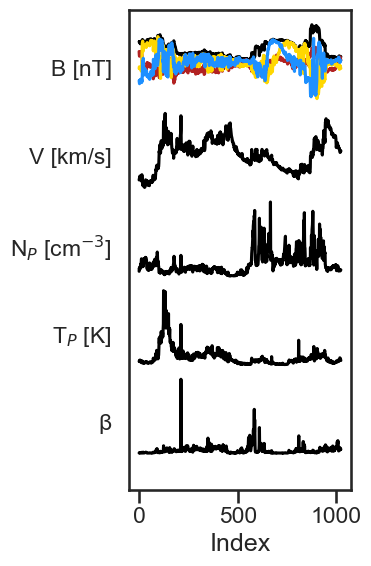

In [70]:
plot_item_minimal(nr)

/var/folders/xy/v4wq5m110gn32553dwbc7d7c0000gn/T/ipykernel_59167/3943884308.py:103: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.2, top=0.8)


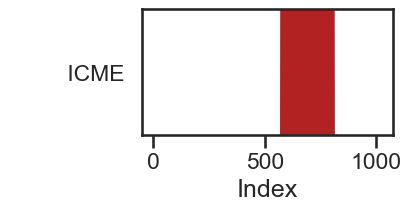

In [71]:
plot_item_minimal_label(nr)

Normalizing line 1: 4.541701594475783 - -4.7007241129636865
Normalizing line 2: 0.8958836141180664 - -1.212491846563286
Normalizing line 3: 5.443607029534533 - -1.0277353320290248
Normalizing line 4: 5.616117925627471 - -0.894445488891141
Normalizing line 5: 1.322335511343857 - -0.19775083783133002


/var/folders/xy/v4wq5m110gn32553dwbc7d7c0000gn/T/ipykernel_59167/3943884308.py:189: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.2, top=0.8)


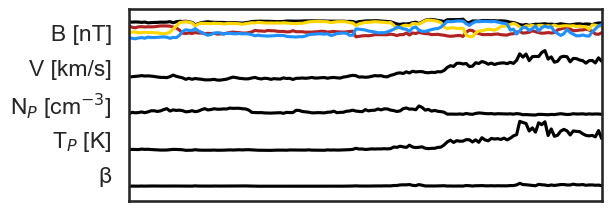

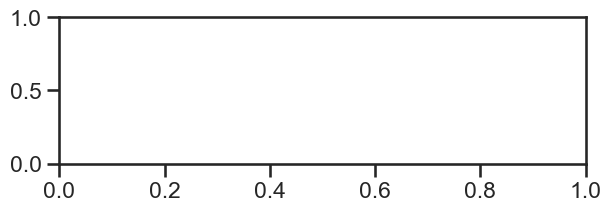

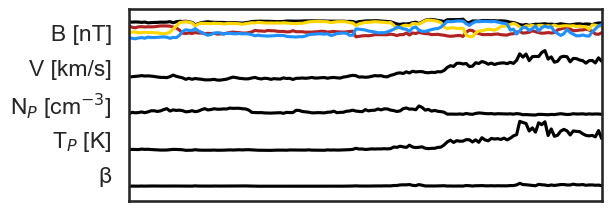

In [72]:
plot_item_minimal_label_end(nr)

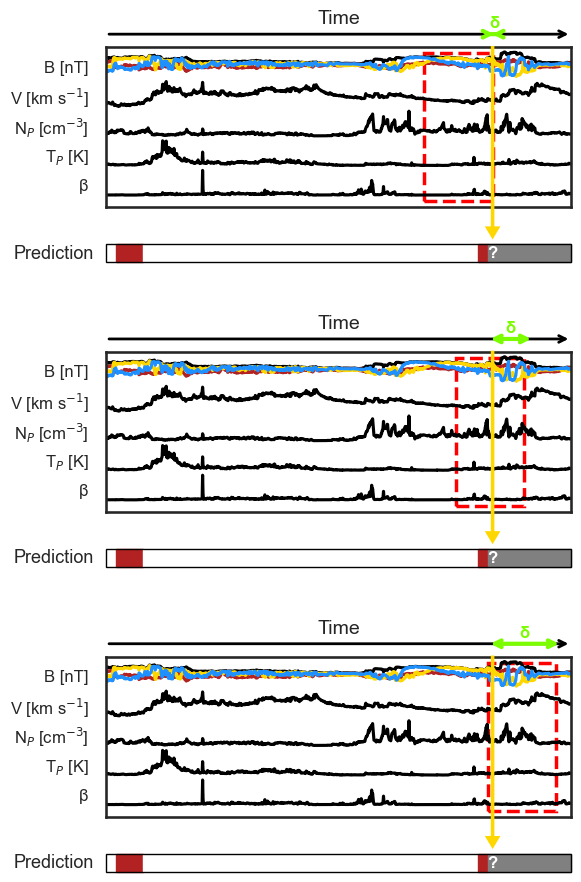

In [92]:
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, FancyArrowPatch


def normalize_series(series_list):
    min_val = min(np.min(s) for s in series_list)
    max_val = max(np.max(s) for s in series_list)
    return [(s - min_val) / (max_val - min_val) for s in series_list]

def add_red_rectangle(ax, x_start, width, y_start=-0.25, y_height=6):
    rect = patches.Rectangle(
        (x_start, y_start), width, y_height,
        linewidth=2.5, edgecolor='red', facecolor='none', linestyle='dashed'
    )
    ax.add_patch(rect)

def plot_waiting_time_panel(item, delta_t, ax=None, label=None):
    if ax is None:
        fig2, ax = plt.subplots(1, 1, figsize=(6, 2))

    time = np.arange(0, item["ICMECAT_catalog-ICME"].shape[0])

    # Extract and normalize data
    B_components = [item["NOAA Realtime Archive_insitu-bt"],
                    item["NOAA Realtime Archive_insitu-bx"],
                    item["NOAA Realtime Archive_insitu-by"],
                    item["NOAA Realtime Archive_insitu-bz"]]
    B_components = normalize_series(B_components)
    line1, line1a, line1b, line1c = B_components

    line2 = (item["NOAA Realtime Archive_insitu-vt"] - np.min(item["NOAA Realtime Archive_insitu-vt"])) / (np.max(item["NOAA Realtime Archive_insitu-vt"]) - np.min(item["NOAA Realtime Archive_insitu-vt"]))
    line3 = (item["NOAA Realtime Archive_insitu-np"] - np.min(item["NOAA Realtime Archive_insitu-np"])) / (np.max(item["NOAA Realtime Archive_insitu-np"]) - np.min(item["NOAA Realtime Archive_insitu-np"]))
    line4 = (item["NOAA Realtime Archive_insitu-tp"] - np.min(item["NOAA Realtime Archive_insitu-tp"])) / (np.max(item["NOAA Realtime Archive_insitu-tp"]) - np.min(item["NOAA Realtime Archive_insitu-tp"]))
    line5 = (item["NOAA Realtime Archive_insitu-beta"] - np.min(item["NOAA Realtime Archive_insitu-beta"])) / (np.max(item["NOAA Realtime Archive_insitu-beta"]) - np.min(item["NOAA Realtime Archive_insitu-beta"]))

    # Plot stacked normalized data
    ax.plot(time, line5, color="black")
    ax.plot(time, line4 + 1*1.2, color="black")
    ax.plot(time, line3 + 2*1.2, color="black")
    ax.plot(time, line2 + 3*1.2, color="black")
    ax.plot(time, line1 + 4*1.2, color="black")
    ax.plot(time, line1a + 4*1.2, label="B$_{X}$", color=geo_magenta)
    ax.plot(time, line1b + 4*1.2, label="B$_{Y}$", color=geo_lime)
    ax.plot(time, line1c + 4*1.2, label="B$_{Z}$", color=geo_green2)

    ax.set_xlim(time[0], time[-1])

    yticklabels = ["β", "T$_{P}$ [K]", "N$_{P}$ [cm$^{-3}$]", "V [km s$^{-1}$]", "B [nT]"]
    ax.set(ylim=[-0.5, 6], yticks=(np.arange(5)+0.35)*1.2, yticklabels=yticklabels)
    ax.tick_params(left=False, bottom=False, labelbottom=False, labelsize=12)

    return ax


# === Main script to generate combined figure ===

# Load your example item once
item = sequential_rtsw.get_data(nr)

fig, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)

x_offset = 425

red_rectangle_specs = [
    (275 + x_offset, 150),    # (x_start, width) for top plot
    (345 + x_offset, 150),   # for middle plot
    (415 + x_offset, 150)    # for bottom plot
]

arrow_positions = [425 + x_offset, 425 + x_offset, 425 + x_offset]  # x-coordinates for arrows (adjust as needed)
arrow_axes = []  # store each axis and x-pos for arrow

plt.subplots_adjust(hspace=0.9) 

waiting_times = [1, 10, 25]
for i, (delta_t, (x_start, width), arrow_x) in enumerate(zip(waiting_times, red_rectangle_specs, arrow_positions)):
    ax = plot_waiting_time_panel(item, delta_t, ax=axes[i])
    add_red_rectangle(ax, x_start, width)
    arrow_axes.append((ax, arrow_x))  # save for later

for ax, x_data in arrow_axes:
    # Convert x_data (in data coordinates) to figure-relative x-position
    x_fig_px = ax.transData.transform((x_data, 0))[0]
    x_fig_rel = fig.transFigure.inverted().transform((x_fig_px, 0))[0]

    # Get vertical position of subplot (in figure coords)
    bbox = ax.get_position()
    y_top = bbox.y1
    y_bottom = bbox.y0 - 0.03  # extend below axis (adjust as needed)

    # Create arrow in figure coordinates
    arrow = FancyArrow(
        x_fig_rel, y_top, 0, y_bottom - y_top,
        width=0.0025, head_width=0.02, head_length=0.01,
        length_includes_head=True, transform=fig.transFigure,
        color='gold'
    )
    fig.patches.append(arrow)

    # add horizontal time arrow above the subplot
    ax.annotate(
        '', xy=(1., 1.08), xycoords='axes fraction',
        xytext=(0., 1.08), textcoords='axes fraction',
        arrowprops=dict(arrowstyle='->', color='black', lw=2),
        fontsize=12
    )
    ax.text(
        0.5, 1.12, "Time", ha='center', va='bottom',
        transform=ax.transAxes, fontsize=14
    )
    

    # Get subplot position in figure coordinates
    bbox = ax.get_position()
    x_start_fig = bbox.x0
    x_end_fig = bbox.x1
    subplot_width = x_end_fig - x_start_fig

    # Box parameters
    num_boxes = 50 # resolution of visual explanation
    box_width_fig = subplot_width / num_boxes
    box_height_fig = 0.018
    y_box_bottom = y_bottom - 0.025

    for j in range(num_boxes):
        x_left = x_start_fig + j * box_width_fig

        if j < 41:
            facecolor = geo_magenta if j in [1,2,3, 40] else 'white'
            question = ""
        elif j == 41:
            facecolor = "gray"
            question = "?"
        else:
            facecolor = "gray"
            question = ""

        # Draw each box
        rect = patches.Rectangle(
            (x_left, y_box_bottom),
            box_width_fig,
            box_height_fig,
            linewidth=1.0,
            edgecolor=facecolor,
            facecolor=facecolor,
            transform=fig.transFigure,
            #zorder=5
        )
        fig.patches.append(rect)

        fig.text(
            x_left + box_width_fig / 2,
            y_box_bottom + box_height_fig / 2,
            question,
            ha='center', va='center',
            fontsize=12, color='white', fontweight='bold',
        )
    # draw a black outline around all boxes
    outline_rect = patches.Rectangle(
        (x_start_fig, y_box_bottom),
        subplot_width,
        box_height_fig,
        linewidth=1,
        edgecolor='black',
        facecolor='none',
        transform=fig.transFigure,
    )
    fig.patches.append(outline_rect)

    # Add y-axis label "Prediction" to the left of the box strip
    fig.text(
        x_start_fig - 0.02,                      # slightly to the left of the subplot
        y_box_bottom + box_height_fig / 2,      # vertically centered on the box strip
        "Prediction", va='center', ha='right',
        fontsize=13, rotation=0
    )

# add the neongreen delta arrow that should be on top of the time axis
arrow_axes[0][0].annotate(
    '', xy=(0.83, 1.08), xycoords='axes fraction',
    xytext=(0.84, 1.08), textcoords='axes fraction',
    arrowprops=dict(arrowstyle='<->', color='lawngreen', lw=3),
    fontsize=12
)
arrow_axes[0][0].text(
    0.835, 1.1, "δ", ha='center', va='bottom', color = 'lawngreen',
    transform=arrow_axes[0][0].transAxes, fontsize=12, fontweight='bold'
)


# add the neongreen delta arrow that should be on top of the time axis
arrow_axes[1][0].annotate(
    '', xy=(0.82, 1.08), xycoords='axes fraction',
    xytext=(0.92, 1.08), textcoords='axes fraction',
    arrowprops=dict(arrowstyle='<->', color='lawngreen', lw=3),
    fontsize=12
)
arrow_axes[1][0].text(
    0.87, 1.1, "δ", ha='center', va='bottom', color = 'lawngreen',
    transform=arrow_axes[1][0].transAxes, fontsize=12, fontweight='bold'
)


# add the neongreen delta arrow that should be on top of the time axis
arrow_axes[2][0].annotate(
    '', xy=(0.82, 1.08), xycoords='axes fraction',
    xytext=(0.98, 1.08), textcoords='axes fraction',
    arrowprops=dict(arrowstyle='<->', color='lawngreen', lw=3),
    fontsize=12
)
arrow_axes[2][0].text(
    0.9, 1.1, "δ", ha='center', va='bottom', color = 'lawngreen',
    transform=arrow_axes[2][0].transAxes, fontsize=12, fontweight='bold'
)

plt.savefig("../../plots/postprocessing2.pdf", bbox_inches='tight')

In [93]:
# extract the df for plotting
df = full_dataset_rtsw.data.copy()
df.index = pd.to_datetime(df["timestamp"], unit="s")

In [94]:
def create_event_plot(event, df, index, delta = 12):
    """
    This function creates a plot of the event with the given index.
    """
    plt.switch_backend('Agg')
    
    begin = event.begin - datetime.timedelta(hours=delta)
    end = event.end + datetime.timedelta(hours=delta)

    # Use searchsorted to find the closest indices for begin and end times
    begin_index = df.index.searchsorted(begin)
    end_index = df.index.searchsorted(end)

    # Ensure that the end_index is not out of bounds
    if end_index == len(df):
        end_index -= 1


    # Create the plot
    fig, axes = plt.subplots(5, 1, figsize=(16, 16))

    axes[0].set_title(f"Event {index}: {event.begin} - {event.end}")

    # Plot the 4 magnetic field components (bx, by, bz, bt) in the first subplot
    axes[0].plot(df.index[begin_index:end_index], df["bx"].iloc[begin_index:end_index], label="B$_{X}$", color=geo_magenta)
    axes[0].plot(df.index[begin_index:end_index], df["by"].iloc[begin_index:end_index], label="B$_{Y}$", color=geo_lime)
    axes[0].plot(df.index[begin_index:end_index], df["bz"].iloc[begin_index:end_index], label="B$_{Z}$", color=geo_green2)
    axes[0].plot(df.index[begin_index:end_index], df["bt"].iloc[begin_index:end_index], label="B$_{TOT}$", color="black")

    
    axes[0].set_ylabel("B [nT]")

    axes[0].axvline(x=event.begin, color="red", linestyle="--")
    axes[0].axvline(x=event.end, color="red", linestyle="--")
    axes[0].legend()

    axes[1].plot(df.index[begin_index:end_index], df["vt"][begin_index:end_index], color = "black")

    axes[1].set_ylabel("V [km/s]")
    axes[1].axvline(x=event.begin, color="red", linestyle="--")
    axes[1].axvline(x=event.end, color="red", linestyle="--")

    axes[2].plot(df.index[begin_index:end_index], df["np"][begin_index:end_index], color = "black")

    axes[2].set_ylabel("N$_{P}$ [cm$^{-3}$]")
    axes[2].axvline(x=event.begin, color="red", linestyle="--")
    axes[2].axvline(x=event.end, color="red", linestyle="--")

    axes[3].plot(df.index[begin_index:end_index], df["tp"][begin_index:end_index], color = "black")

    axes[3].set_ylabel("T$_{P}$ [K]")
    axes[3].axvline(x=event.begin, color="red", linestyle="--")
    axes[3].axvline(x=event.end, color="red", linestyle="--")

    axes[4].plot(df.index[begin_index:end_index], df["beta"][begin_index:end_index], color = "black")
    
    axes[4].set_ylabel("\u03B2")
    axes[4].axvline(x=event.begin, color="red", linestyle="--")
    axes[4].axvline(x=event.end, color="red", linestyle="--")
    
    plt.tight_layout()
    plt.savefig(f"../../plots/event_{index}.png")
    
    plt.close(fig)

In [95]:
#for i, event in tqdm(enumerate(events_rtsw)):
#    create_event_plot(event, df, i)